In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Image functions
from skimage.color import rgb2gray
from skimage import filters
from skimage.transform import resize, rescale
from skimage.filters import gaussian

In [33]:
def prep_im_and_gt(im_id, im_dir_path, gt_dir_path, scalar = 1):
    '''Prepare image and corresponding ground truth segmentation from test images. 
    Paths to directories containing image and ground truth files required.
    If parameter scalar is passed, output image will be scaled by it. Defualt 1 retains original size.

    Args:
        im_id (str): image ID
        im_dir_path (str): image directory path 
        gt_dir_path (str): ground thruth directory path
        scalar (float, optional): rescale coefficient

    Returns:
        im (numpy.ndarray): image
        gt (numpy.ndarray): ground truth segmentation.
    '''

    # Read and resize image
    im = plt.imread(im_dir_path + im_id + ".png")[:, :, :3] #Some images have fourth, empty color chanel which we slice of here
    im = rescale(im, scalar, channel_axis = 2, anti_aliasing=True)

    #Read and resize ground truth segmentation
    gt = plt.imread(gt_dir_path + im_id + "_GT.png")
    gt = rescale(gt, scalar, anti_aliasing=False)

    #Return GT to binary
    binary_gt = np.zeros_like(gt)
    binary_gt[gt > .5] = 1
    gt = binary_gt.astype(int)

    return im, gt

In [34]:
im, gt = prep_im_and_gt('PAT_46_881_939', 'test_images/', 'test_image_groundtruths/', 0.25)

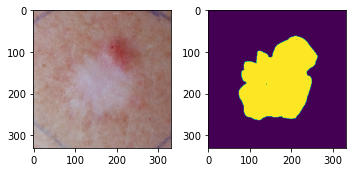

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(im)
axes[1].imshow(gt)
fig.tight_layout()